# Duboko učenje - laboratorijska vježba - generativni modeli - Generative adversarial networks (GAN)

Primarna namjena GAN-a je isto generiranje novih i uvjerljivih uzoraka, no princip rada je malo drugačiji od prethodna dva modela. GAN ne procjenjuje direktno parametre $p(\mathbf x)$ ili bilo koje druge distribucije, premda se njegovo treniranje može interpretirati kao estimacija $p(\mathbf x)$. Najvjerojatnije zahvaljujući tom drugačijem pristupu, GAN-ovi često generiraju vizualno najbolje uzorke u usporedbi sa VAE ili drugim generativnim mrežama.

GAN se sastoji od dvije zasebne mreže 

1. Generator (G) koji ima zadatak generirati uvjerljive uzorke
2. Diskriminator (D) koji ima zadatak prepoznati radi li se o pravom uzorku (iz skupa za treniranje) ili lažnom uzorku koji je generirao G

<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/GAN.svg" width="30%">
</div>
</center>

Te dvije mreže su protivnici (Adversaries), imaju dijametralno suprotstavljene ciljeve te se pokušavaju nadmudriti. To nadmetanje ih tjera da budu sve bolji u postizanju svog cilja i da se fokusiraju na sve bitne detalje ulaznih podataka. Očekivano, njihovo nadmetanje trebalo bi dovesti do toga da generator generira savršene uzorke koje diskriminator ne može razlikovati od uzoraka iz skupa za treniranje. Da bi generator postigao takav uspjeh nužno je da i diskriminator bude maksimalno dobar u svom zadatku.

Generator na svojem izlazu generira uzorke za neki slučajni ulazni vektor koji prati neku distribuciju. Ta slučajnost na ulazu omogućuje generatoru da uvijek generira nove uzorke. Pri tome nema nekih posebnih ograničenja na arhitekturu generatora, no poželjno je da se može trenirati backpropagation algoritmom. 

<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/G.svg" width="30%">
</div>
</center>

Diskriminator na svome izlazu treba estimirati pripadnost razredu stvarnih ili lažnih uzoraka za svaki ulazni vektor. Za razliku od generatora, ovdje je moguće koristiti učenje pod nadzorom jer se za svaki uzorak zna da li je došao iz skupa za treniranje ili od generatora. Radi jednostavnosti možemo izlaz diskriminatora ograničiti u rasponu $[0,1]$ i interpretirati kao vjerojatnost da je ulazni uzorak stvaran (iz skupa za treniranje).

    
<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/D.svg" width="30%">
</div>
</center>
    

Gore opisani ciljevi diskriminatora i generatora mogu se formalno izraziti u sljedećoj funkciji cilja:

$\min_G \max_D V(D,G) = E_{ \mathbf x \sim p_{data}(\mathbf x) } [\log D( \mathbf x)] + E_{ \mathbf z  \sim p_{\mathbf z}(\mathbf z) } [\log(1 - D(G( \mathbf z)))]$

Prvi pribrojnik predstavlja očekivanje procjene log vjerojatnosti da su uzorci iz skupa za treniranje stvarni. Drugi pribrojnik predstavlja očekivanje procjene log vjerojatnosti da generirani uzorci nisu stvarni, tj. da su umjetni. Diskriminator ima za cilj maksimizirati oba pribrojnika, dok generator ima za cilj minimizirati drugi pribrojnik. Svaki pribrojnik funkcije cilja može se jednostavno procijeniti za jednu mini grupu te se može procijeniti gradijent s obzirom na prametre obiju mreža. 

Treniranje dviju mreža (G i D) može se provesti istovremeno ili se u jednoj iteraciji prvo može trenirati jedna mreža a zatim druga. Dodatno, neki autori preporučuju da se u nekoliko uzastopnih iteracija trenira jedna mreža, a nakon toga druga mreža samo jednu iteraciju.

    
<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/GAN2.svg" width="50%">
</div>
</center>


Kod generiranja slika uspješnim se pokazao Deep Convolutional GAN (DCGAN) koji u skrivenim slojevima obiju mreža koristi konvolucijske slojeve. Za razliku od klasičnih konvolucijskih mreža, ovdje se ne koriste pooling slojevi nego se uzorkovanje provodi pomoću konvolucijskih slojeva koji imaju posmak veći od 1. Autori mreže preporučuju korištenje Batch normalizacije u svim slojevima osim u izlaznom sloju generatora te ulaznom i izlaznom sloju diskriminatora. Korištenje Leaky ReLU aktivacijskih funkcija u svim slojevima osim u izlaznim je još jedna specifičnost DCGAN-a kao i eliminacija potpuno povezanih slojeva.

    
<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/DCGAN.svg" width="50%">
</div>
</center>

### U sljedećih nekoliko blokova koda nalaze se inicijalizacijske postavke i gotove pomoćne funkcije

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torchvision import datasets, transforms
import tqdm
from torchvision.utils import make_grid

import torch.distributions as tdist

import numpy as np
import tqdm

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def prepare_data_loaders(batch_size=32):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(64),
                                    torchvision.transforms.ToTensor()
                               ])), batch_size=batch_size)

    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./files', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.Resize(64),
                                       torchvision.transforms.ToTensor()
                                   ])), batch_size=batch_size)
    
    return train_loader, test_loader

### 5. Zadatak

Implementirajte DCGAN s generatorom i diskriminatorom. Arhitekura treba biti:
    
* Generator
    * Sloj 1 - Broj izlaznih kanala = 512, veličina jezgre = 4, veličina koraka = 1
    * Sloj 2 - Broj izlaznih kanala = 256, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 3 - Broj izlaznih kanala = 128, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 4 - Broj izlaznih kanala = 64, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 5 - Broj izlaznih kanala = 1, veličina jezgre = 4, veličina koraka = 2, padding = 1

* Diskriminator
    * Sloj 1 - Broj izlaznih konvolucija = 64, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 2 - Broj izlaznih konvolucija = 128, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 3 - Broj izlaznih konvolucija = 256, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 4 - Broj izlaznih konvolucija = 512, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 5 - Broj izlaznih konvolucija = 1, veličina jezgre = 4, veličina koraka = 1, padding = 0

Ulaz u generator $\mathbf z$ neka ima 100 elemenata prema normalnoj distribuciji $N(0,1)$. Ulazni podaci neka su MNIST brojevi skalirani na veličinu 64x64 te treniranje provedite kroz barem 20 epoha. U jednoj iteraciji provedite jednu optimizaciju generatora i jednu optimizaciju diskriminatora s po jednom mini grupom. Koristite tanh aktivacijsku funkciju za izlaz generatora i sigmoid aktivaciju za izlaz diskriminator, a za ostaje slojeve "propustljivi" ReLU sa "negative_slope" parametrom od 0.2. Batch noramlizacija (jedan od podzadataka) ide iza svakog sloja.

**Podzadaci:**

 1. Vizualizirajte rezultate generiranja 100 novih uzoraka iz slučajnih vektora $\mathbf z$. Usporedite rezultate s uzorcima generiranim pomoću VAE.
 2. Spremite težine istreniranog modela u datoteku "zad5_gan.th" i uploadajte tu datoteku na Moodle.
 3. Na Moodle predajte vizualizaciju 1. podzadatka.
 4. Odgovorite na sljedeća pitanja **u bilježnici**. Bilježnicu na kraju predajte na Moodle.


Koristite sljedeći predložak:

**NAPOMENA**: Osim nadopunjavanja koda koji nedostaje, predložak se treba prilagođavati prema potrebi, a može i prema vlastitim preferencijama. Stoga **budite oprezni s tvrdnjama da vam neki dio koda ne radi!**

**Pitanje:**
    
U jednoj iteraciji provedite treniranje diskriminatora sa dvaje minigrupe a generatora sa jednom minigrupom. Ponovite isti postupak samo zamijenite mjesta generatora i diskriminatora. Vizualizirajte generirane uzorke i komentirajte retzultate.

**Odgovor:**

**Pitanje:**

Isključite batch normalizaciju u obje mreže. Komentirajte rezultate.

**Odgovor:**

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_size=100):
        super(Generator, self).__init__()
        self.latent_size = latent_size

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.tanh = nn.Tanh()

        self.layer1 = nn.ConvTranspose2d(in_channels=latent_size, out_channels=512, kernel_size=4, stride=1)
        self.batchnorm1 =  nn.BatchNorm2d(512)

        self.layer2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.batchnorm2 =  nn.BatchNorm2d(256)

        self.layer3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.batchnorm3 =  nn.BatchNorm2d(128)

        self.layer4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm4 =  nn.BatchNorm2d(64)

        self.layer5 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.batchnorm1(x)
        x = self.lrelu(x)

        x = self.layer2(x)
        x = self.batchnorm2(x)
        x = self.lrelu(x)

        x = self.layer3(x)
        x = self.batchnorm3(x)
        x = self.lrelu(x)

        x = self.layer4(x)
        x = self.batchnorm4(x)
        x = self.lrelu(x)

        x = self.layer5(x)
        return self.tanh(x)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

        self.layer1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)

        self.layer2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.batchnorm2 =  nn.BatchNorm2d(128)

        self.layer3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.batchnorm3 =  nn.BatchNorm2d(256)

        self.layer4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.batchnorm4 =  nn.BatchNorm2d(512)

        self.layer5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0)

    def forward(self, x):
        x = self.layer1(x)
        x = self.lrelu(x)

        x = self.layer2(x)
        x = self.batchnorm2(x)
        x = self.lrelu(x)

        x = self.layer3(x)
        x = self.batchnorm3(x)
        x = self.lrelu(x)

        x = self.layer4(x)
        x = self.batchnorm4(x)
        x = self.lrelu(x)

        x = self.layer5(x)
        x = self.sigmoid(x)
        return x.squeeze()

In [5]:
dmodel = Discriminator()
gmodel = Generator()

In [6]:
def train(gmodel: Generator, dmodel: Discriminator, n_epochs=10, log_epochs=1, batch_size=32, learning_rate=1e-3, device='cpu'):
    train_loader, test_loader = prepare_data_loaders(batch_size=batch_size)
    
    gmodel = gmodel.to(device)
    dmodel = dmodel.to(device)
    
    gmodel.train()
    dmodel.train()
    
    criterion = nn.BCELoss()
    
    g_optim = optim.Adam(gmodel.parameters(), lr=learning_rate)
    d_optim = optim.Adam(dmodel.parameters(), lr=learning_rate)
    
    for epoch_idx in range(0, n_epochs):
        
        g_loss, d_loss = 0, 0
        
        for image_data, _ in tqdm.tqdm(train_loader):
            # discriminator update
            dmodel.zero_grad()
            
            # real data pass
            image_data = image_data.to(device)
            
            batch_size = image_data.shape[0]
            labels = torch.ones(batch_size, device=device).float()
            
            d_output = dmodel(image_data).view(-1)
            d_err_real = criterion(d_output, labels)
            d_err_real.backward()
            d_loss += d_err_real.item() / batch_size


            # fake data pass
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_image_data = gmodel(noise)
            labels = torch.zeros(batch_size, device=device).float()
            

            d_output = dmodel(fake_image_data.detach()).view(-1)
            d_error_fake = criterion(d_output, labels)
            d_error_fake.backward()
            d_loss += d_error_fake.item() / batch_size
            d_optim.step()

            # generator update
            gmodel.zero_grad()
            
            labels = torch.ones(batch_size, device=device)
            d_output = dmodel(fake_image_data).view(-1)
            g_error = criterion(d_output, labels)
            g_error.backward()
            g_loss += g_error.item() / batch_size 
            g_optim.step()

            
        if (epoch_idx + 1) % log_epochs == 0:
            print(f"[{epoch_idx+1}/{n_epochs}]: d_loss = {d_loss:.5f} g_loss {g_loss:.5f}")
            
    gmodel.eval()
    dmodel.eval()
    
    return gmodel, dmodel

In [7]:
gmodel, dmodel = train(gmodel, dmodel, n_epochs=20, batch_size=128, device='cuda')

100%|██████████| 469/469 [01:35<00:00,  4.91it/s]


[1/20]: d_loss = 0.79622 g_loss 27.70308


100%|██████████| 469/469 [01:32<00:00,  5.10it/s]


[2/20]: d_loss = 0.65472 g_loss 28.46787


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[3/20]: d_loss = 0.34935 g_loss 33.79438


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[4/20]: d_loss = 0.00410 g_loss 35.71572


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[5/20]: d_loss = 1.37397 g_loss 34.76746


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[6/20]: d_loss = 0.00465 g_loss 36.12057


100%|██████████| 469/469 [01:31<00:00,  5.13it/s]


[7/20]: d_loss = 0.38240 g_loss 37.29835


100%|██████████| 469/469 [01:31<00:00,  5.13it/s]


[8/20]: d_loss = 0.49112 g_loss 26.39512


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[9/20]: d_loss = 0.51271 g_loss 27.18234


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[10/20]: d_loss = 0.47681 g_loss 29.66286


100%|██████████| 469/469 [01:31<00:00,  5.15it/s]


[11/20]: d_loss = 0.37238 g_loss 29.26335


100%|██████████| 469/469 [01:31<00:00,  5.15it/s]


[12/20]: d_loss = 1.03000 g_loss 23.59705


100%|██████████| 469/469 [01:31<00:00,  5.15it/s]


[13/20]: d_loss = 0.98587 g_loss 21.02138


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[14/20]: d_loss = 1.14081 g_loss 20.34461


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[15/20]: d_loss = 0.63633 g_loss 23.24219


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[16/20]: d_loss = 0.68800 g_loss 23.55866


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[17/20]: d_loss = 0.85489 g_loss 25.31664


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[18/20]: d_loss = 0.85105 g_loss 22.41029


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


[19/20]: d_loss = 0.46184 g_loss 27.08413


100%|██████████| 469/469 [01:31<00:00,  5.14it/s]

[20/20]: d_loss = 0.93813 g_loss 24.13228


In [11]:
random_sample = gmodel(torch.randn(100, 100, 1, 1).to('cuda')).view(100, 64, 64).data.cpu().numpy()

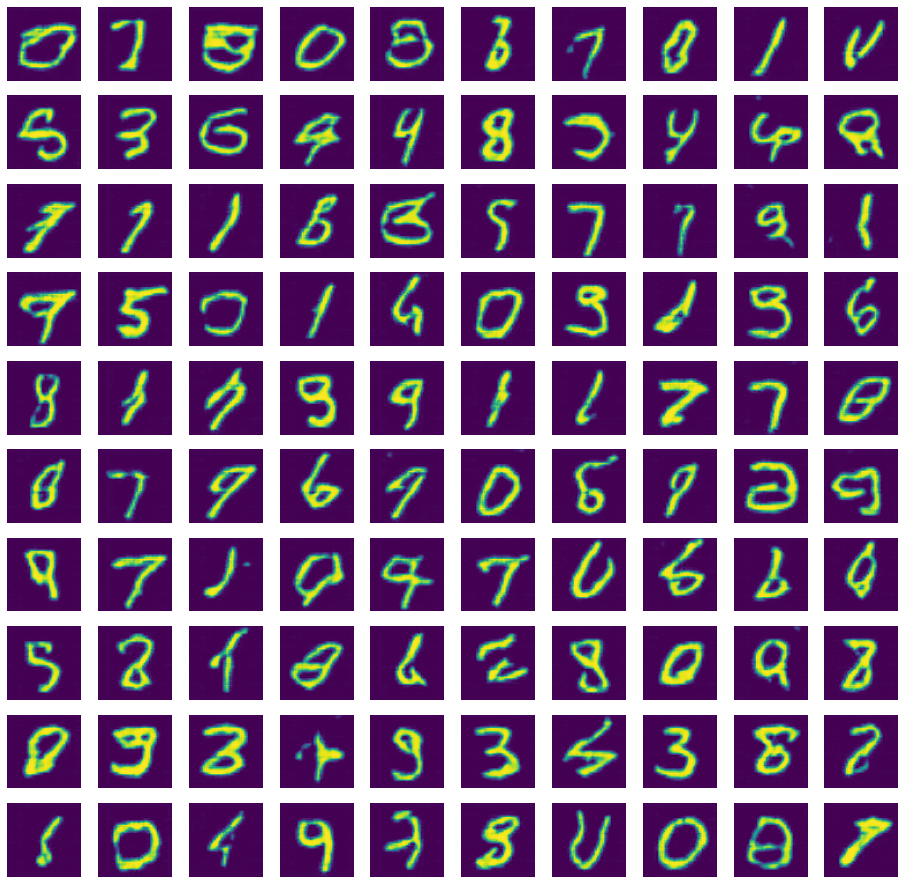

In [12]:
plt.figure(figsize=(16, 16))
for idx in range(0, 100):
    plt.subplot(10, 10, idx+1)
    plt.imshow(random_sample[idx, ...])
    plt.clim(0, 1)
    plt.axis('off')

In [13]:
with open('zad5_gan.th', 'wb') as f:
    torch.save(gmodel.state_dict(), f)